In [1]:
from pauls_functions_advanced import *
from experiment_functions import *
import pandas as pd
from pmlb import fetch_data, classification_dataset_names
from sklearn.model_selection import train_test_split
from interpretableai import iai
from sklearn.preprocessing import StandardScaler

In [2]:
import pandas as pd
def get_feature_type(x, include_binary=False):
    x.dropna(inplace=True)
    if not check_if_all_integers(x):
        return 'continuous'
    else:
        if x.nunique() > 10:
            return 'continuous'
        if include_binary:
            if x.nunique() == 2:
                return 'binary'
        return 'categorical'

def get_target_type(x, include_binary=False):
    x.dropna(inplace=True)
    if x.dtype=='float64':
        return 'continuous'
    elif x.dtype=='int64':
        if include_binary:
            if x.nunique() == 2:
                return 'binary'
        return 'categorical'
    else:
        raise ValueError("Error getting type")

def check_if_all_integers(x):
    "check a pandas.Series is made of all integers."
    return all(float(i).is_integer() for i in x.unique())
def corr_data_for(df):
    TARGET_NAME = 'target'
    feat_names = [col for col in df.columns if col!=TARGET_NAME]
    types = [get_feature_type(df[col], include_binary=True) for col in feat_names]
    col = pd.DataFrame(feat_names,types)
    cat_col = col[col.index == 'categorical']
    cat_col = cat_col[0].tolist()
    dummy_col = pd.get_dummies(data=df, columns=cat_col)
    add_col = dummy_col.shape[1] - df.shape[1]
    if (add_col < df.shape[0] *0.3) & (dummy_col.shape[1] <  df.shape[0]):
        df = dummy_col
    else:
        del df
        df = pd.DataFrame()
    return df

In [3]:
# from sklearn.datasets import load_breast_cancer
# data = load_breast_cancer()
# data_df = pd.DataFrame(data.data, columns=data.feature_names)
# data_df['diagnosis'] = data.target
# features = data_df.iloc[:, 0:30]
# diagnosis = data_df.iloc[:, 30]
# orig_cols = data_df.iloc[:, 0:30].columns
# # random = 20 #random number to fix seed

In [4]:
# df = fetch_data(classification_dataset_names[0])

In [5]:
classification_dataset_names.remove('analcatdata_creditscore')

In [6]:
iters=3
res_rul = {}
sc = StandardScaler()
names = ['Reg-CART','CART','ORT','OCT','ORT-H','OCT-H']
for classification_dataset in classification_dataset_names:
    df = fetch_data(classification_dataset)
    df = corr_data_for(df)
    if df.empty:
        continue
    y = df['target']
    X = df.loc[:, df.columns != 'target']
#performance_by_iter = pd.DataFrame(columns = ["Logistic Regression", "CART_rules", "OCT_rules", "OCTH_rules", "CART_rules_and_features", "OCT_rules_and_features", "OCTH_rules_and_features"], index = np.arange(0, iters))
    print(color.BOLD + '\n\n    ----------------------------------------- section {} -----------------------------------------'.format(classification_dataset) + color.END)
    print(X.shape)
    for it in range(iters):
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = it, stratify=y)
        X_col = X_train.columns
        X_test.name = "X_test"
        X_train.name = "X_train"
        X_train = sc.fit_transform(X_train)
        X_test = sc.transform(X_test)
        X_train = pd.DataFrame(X_train,columns=X_col)
        X_test = pd.DataFrame(X_test,columns=X_col)



        models, performance = generate_tree(X_train, y_train, X_test, y_test, n_num=1, feat_size=len(X.columns),  max_iter_hy=2, depth_bi=3, depth_hy=2, complexity_bi=0.001, complexity_hy=0.001, depth_grid_bi=False, depth_grid_hy=False, Reg_CART=False, ORT=False, ORT_H=False, Clas_CART=True, OCT=True, OCT_H=False)

        act_name = []
        act_rules = []
        for model,name in zip(models,names):
            if not not model:
                act_name += [name]
                act_rules += [model]

        datasets = gen_train_and_test_features(act_rules ,act_name , X_train, X_test)
        for model in datasets.keys():

            X_train_rules_and_features, X_test_rules_and_features = datasets[model][0]
            X_train_only_rules, X_test_only_rules = datasets[model][1]
            only_rules_acc = log_regression_pipeline(X_train_only_rules, X_test_only_rules, y_train, y_test)
            rules_and_features_acc = log_regression_pipeline(X_train_rules_and_features, X_test_rules_and_features, y_train, y_test)

            res_rul[(classification_dataset,model + "_rules",it)] = only_rules_acc
            res_rul[(classification_dataset,model + "_rules_and_features",it)] = rules_and_features_acc

            # performance_by_iter.loc[iter, model + "_rules"] = only_rules_acc
            # performance_by_iter.loc[iter, model + "_rules_and_features"] = rules_and_features_acc

        log_reg_acc = log_regression_pipeline(X_train, X_test, y_train, y_test)
        res_rul[(classification_dataset,'Logistic_Regression',it)] = log_reg_acc



    ----------------------------------------- section GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1 -----------------------------------------
(1600, 60)
Classification CART mean performance:  0.50625


Classification OCT performance:  0.646875


Classification CART mean performance:  0.49687499999999996


Classification OCT performance:  0.665625


Classification CART mean performance:  0.528125


Classification OCT performance:  0.6625




    ----------------------------------------- section GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1 -----------------------------------------
(1600, 56)
Classification CART mean performance:  0.50625


Classification OCT performance:  0.8125


Classification CART mean performance:  0.5


Classification OCT performance:  0.7875


Classification CART mean performance:  0.49687499999999996


Classification OCT performance:  0.7875




    ----------------------------------------- section GAMETES_Epistasis_3_Way_20atts_0.2H_EDM_1_1 -----------------------

KeyError: 'DMFT_End_0'

In [16]:
act_rules

[["(feature['Ethnic_1'] < 0.224) & (feature['DMFT_End_0'] < 0.466) & (feature['DMFT_Begin_0'] < 0.716)",
  "(feature['Ethnic_1'] < 0.224) & (feature['DMFT_End_0'] < 0.466) & (feature['DMFT_Begin_0'] >= 0.716)",
  "(feature['Ethnic_1'] < 0.224) & (feature['DMFT_End_0'] >= 0.466) & (feature['DMFT_Begin_8'] < 1.859)",
  "(feature['Ethnic_1'] < 0.224) & (feature['DMFT_End_0'] >= 0.466) & (feature['DMFT_Begin_8'] >= 1.859)",
  "(feature['Ethnic_1'] >= 0.224) & (feature['DMFT_Begin_0'] < 0.716) & (feature['DMFT_Begin_7'] < 1.509)",
  "(feature['Ethnic_1'] >= 0.224) & (feature['DMFT_Begin_0'] < 0.716) & (feature['DMFT_Begin_7'] >= 1.509)",
  "(feature['Ethnic_1'] >= 0.224) & (feature['DMFT_Begin_0'] >= 0.716) & (feature['Gender'] < -0.03)",
  "(feature['Ethnic_1'] >= 0.224) & (feature['DMFT_Begin_0'] >= 0.716) & (feature['Gender'] >= -0.03)"],
 ["(feature['Ethnic_2'] < 0.024) & (feature['DMFT_Begin_0'] < 0.716) & (feature['Ethnic_1'] < 0.224)",
  "(feature['Ethnic_2'] < 0.024) & (feature['DMF

In [12]:
df.loc[eval(rule)].index.values

,Gender,DMFT.Begin_0,DMFT.Begin_1,DMFT.Begin_2,DMFT.Begin_3,DMFT.Begin_4,DMFT.Begin_5,DMFT.Begin_6,DMFT.Begin_7,DMFT.Begin_8,DMFT.End_0,DMFT.End_1,DMFT.End_2,DMFT.End_3,DMFT.End_4,DMFT.End_5,DMFT.End_6,Ethnic_0,Ethnic_1,Ethnic_2
0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
2,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1
4,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
792,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1
793,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
794,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1
795,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [14]:
X_train

,Gender,DMFT.Begin_0,DMFT.Begin_1,DMFT.Begin_2,DMFT.Begin_3,DMFT.Begin_4,DMFT.Begin_5,DMFT.Begin_6,DMFT.Begin_7,DMFT.Begin_8,DMFT.End_0,DMFT.End_1,DMFT.End_2,DMFT.End_3,DMFT.End_4,DMFT.End_5,DMFT.End_6,Ethnic_0,Ethnic_1,Ethnic_2
0,-1.030286,-0.513701,-0.328369,-0.362545,-0.339980,2.737395,-0.348538,-0.342847,-0.301253,-0.251871,-0.637323,-0.518579,-0.466876,2.531201,-0.31349,-0.275705,-0.160514,-0.370810,-0.801095,1.023832
1,-1.030286,-0.513701,-0.328369,-0.362545,2.941346,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,-0.637323,-0.518579,2.141896,-0.395069,-0.31349,-0.275705,-0.160514,-0.370810,-0.801095,1.023832
2,-1.030286,1.946657,-0.328369,-0.362545,-0.339980,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,1.569062,-0.518579,-0.466876,-0.395069,-0.31349,-0.275705,-0.160514,2.696799,-0.801095,-0.976723
3,0.970605,-0.513701,3.045356,-0.362545,-0.339980,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,-0.637323,-0.518579,2.141896,-0.395069,-0.31349,-0.275705,-0.160514,-0.370810,-0.801095,1.023832
4,0.970605,-0.513701,-0.328369,2.758280,-0.339980,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,-0.637323,-0.518579,2.141896,-0.395069,-0.31349,-0.275705,-0.160514,-0.370810,1.248292,-0.976723
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
632,-1.030286,1.946657,-0.328369,-0.362545,-0.339980,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,1.569062,-0.518579,-0.466876,-0.395069,-0.31349,-0.275705,-0.160514,-0.370810,-0.801095,1.023832
633,-1.030286,-0.513701,-0.328369,-0.362545,-0.339980,-0.365311,-0.348538,2.916756,-0.301253,-0.251871,-0.637323,-0.518579,-0.466876,-0.395069,-0.31349,-0.275705,6.229968,-0.370810,1.248292,-0.976723
634,0.970605,1.946657,-0.328369,-0.362545,-0.339980,-0.365311,-0.348538,-0.342847,-0.301253,-0.251871,1.569062,-0.518579,-0.466876,-0.395069,-0.31349,-0.275705,-0.160514,-0.370810,-0.801095,1.023832
635,-1.030286,-0.513701,-0.328369,-0.362545,-0.339980,-0.365311,-0.348538,2.916756,-0.301253,-0.251871,-0.637323,-0.518579,-0.466876,-0.395069,-0.31349,3.627059,-0.160514,-0.370810,1.248292,-0.976723


In [7]:
k = pd.DataFrame(res_rul,index=[0])
k = k.stack(level=2).sort_index()
k = k.swaplevel(axis=1)
t=k.mean(level=0,axis=1)
t.mean(level=0)

C:\Users\paulr\AppData\Local\Temp\ipykernel_35332\1329275191.py:4: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  t=k.mean(level=0,axis=1)
C:\Users\paulr\AppData\Local\Temp\ipykernel_35332\1329275191.py:5: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  t.mean(level=0)


,CART_rules,CART_rules_and_features,Logistic_Regression,OCT_rules,OCT_rules_and_features
0,0.727519,0.760548,0.750987,0.797939,0.811692


ValueError: min() arg is an empty sequence

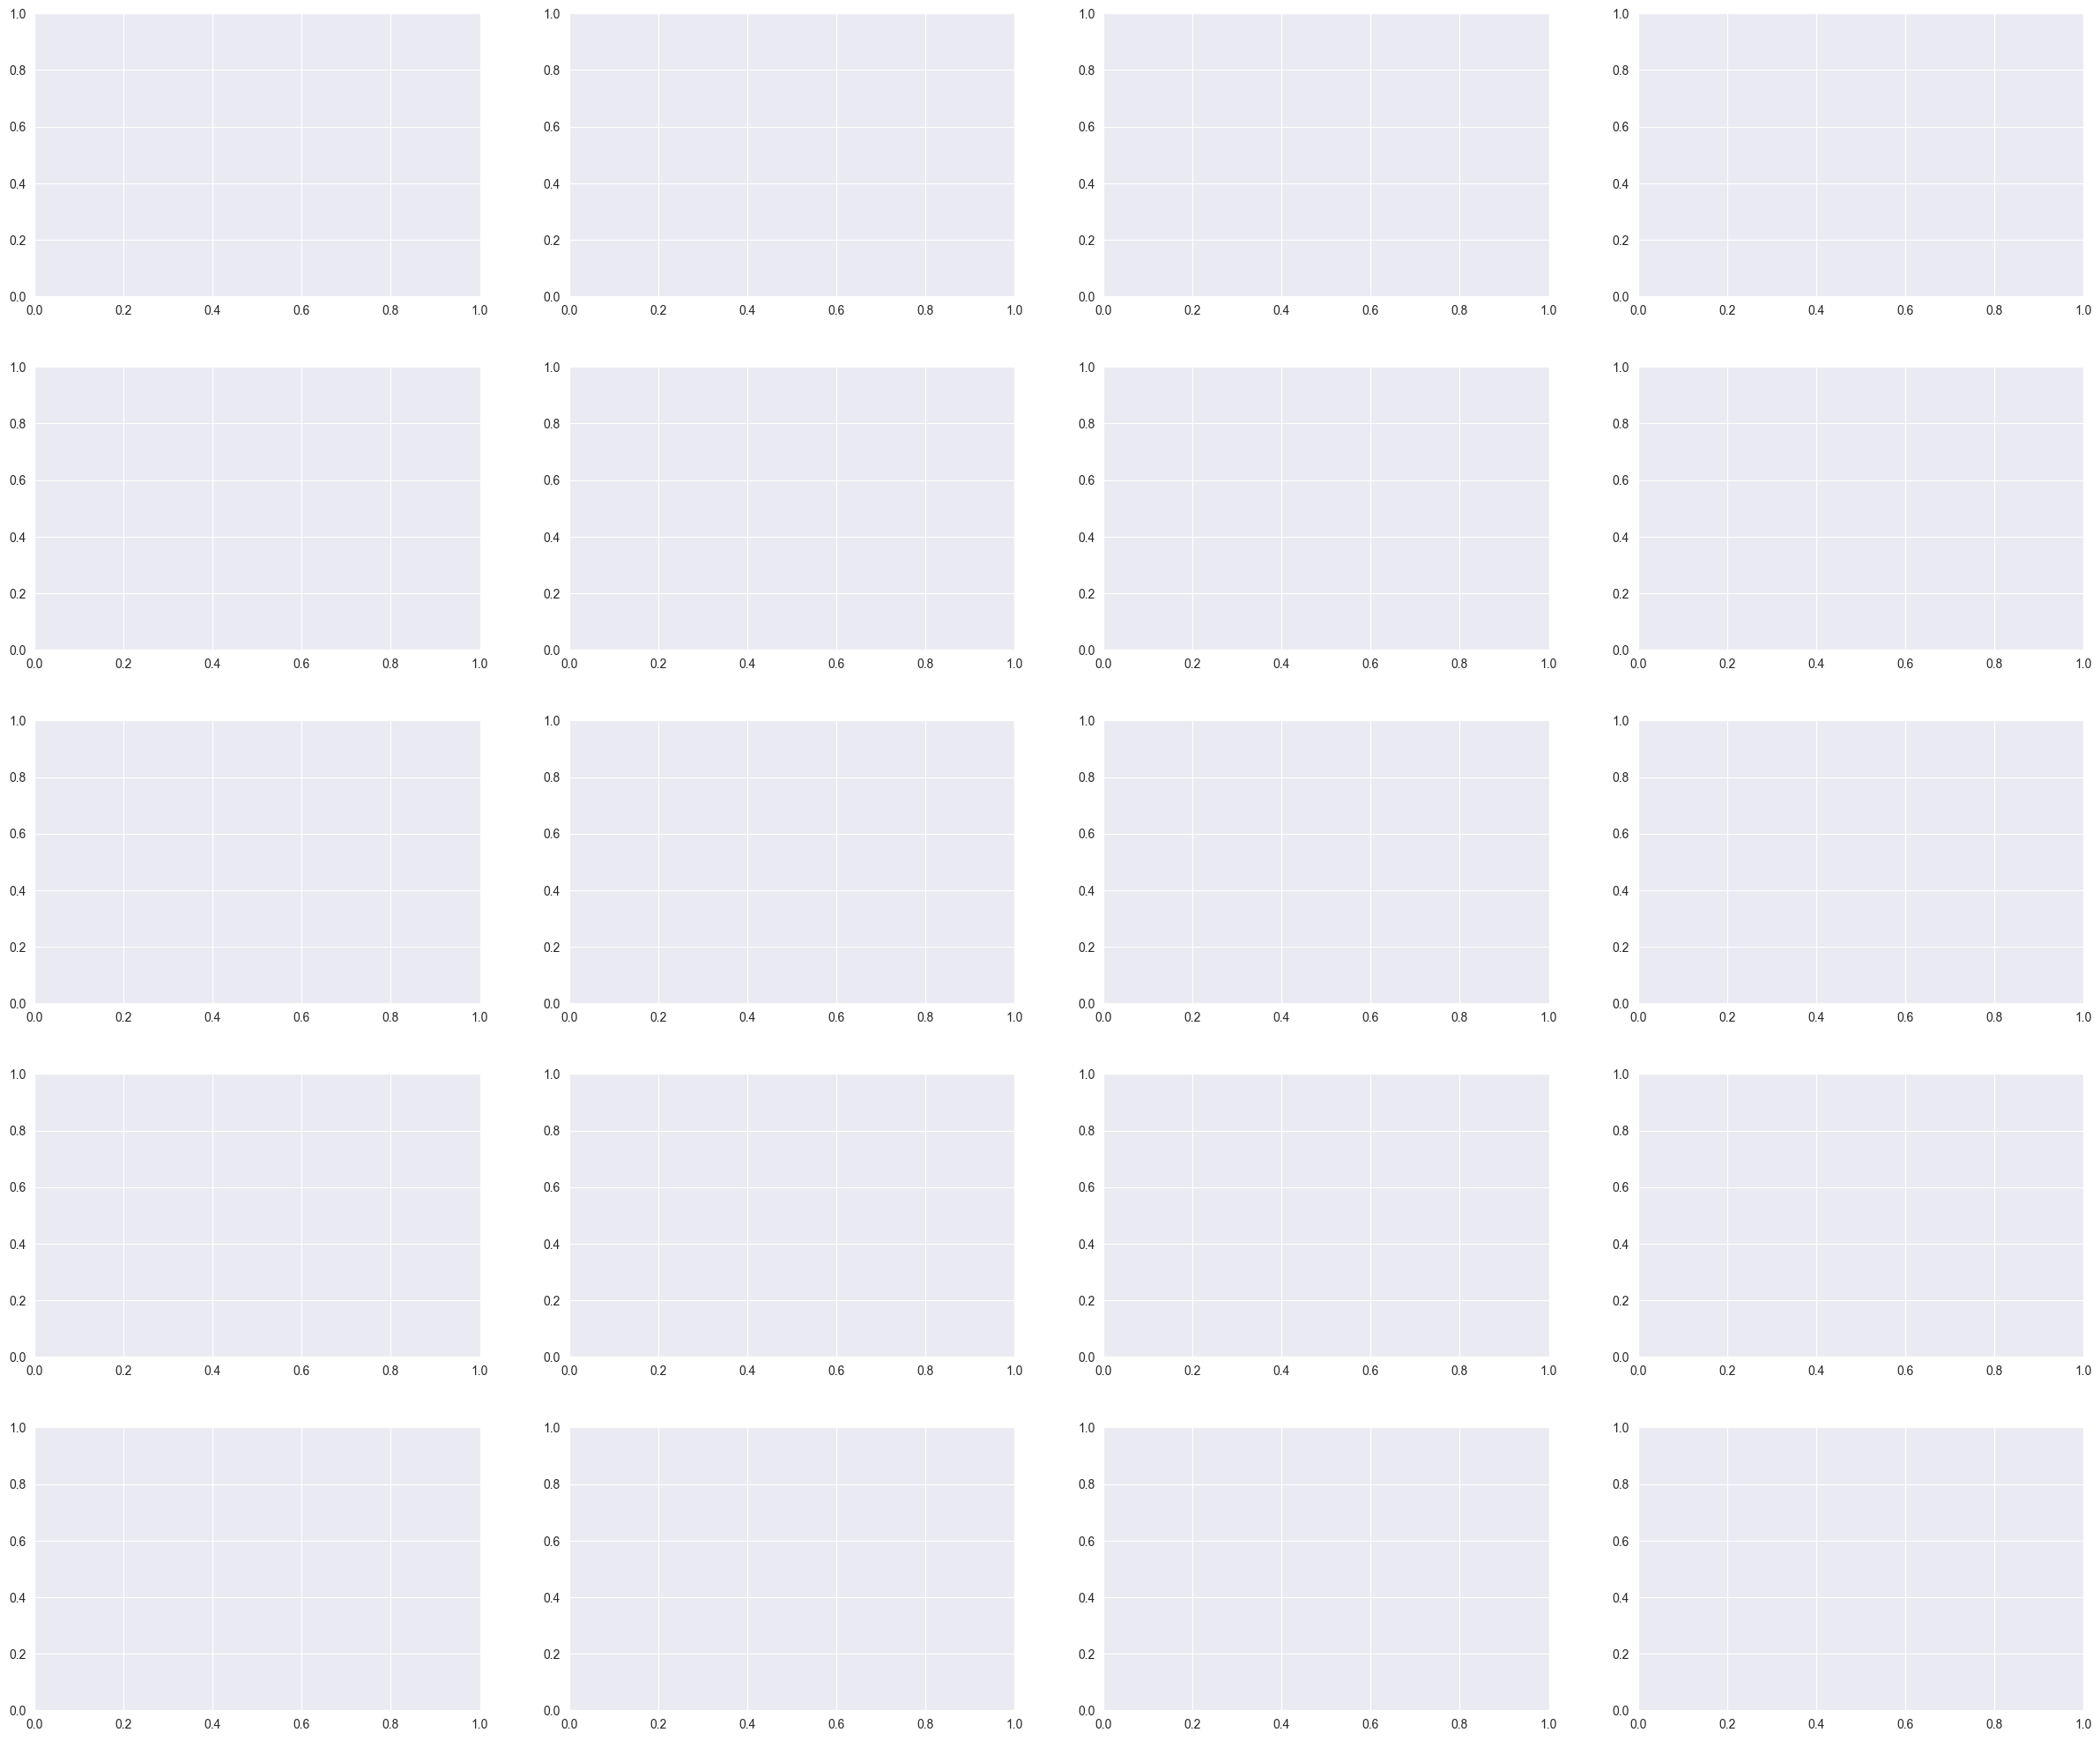

In [10]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows = 5, ncols = 4, gridspec_kw = {"hspace": 0.25})
import seaborn as sns
fig.set_size_inches(30, 25)
iteration = 0

for m in range(5):
    for j in range(4):

        dataset = classification_dataset_names[:20][iteration]

        columns = [i for i in k.columns if dataset in i]
        sns.boxplot(k[columns], ax = ax[m, j])

        ax[m, j].set_title(dataset)

        ax[m, j].set_xticklabels(['CART Rules', "OCT Rules", "Logistic Regression", "RuleFit", "ORRFA"])

        iteration += 1



In [ ]:
CART_rules

In [ ]:
import seaborn as sns

sns.violinplot(data=k)

In [ ]:
del performance_by_iter['OCTH_rules']

In [ ]:
del performance_by_iter['OCTH_rules_and_features']

In [ ]:
df.loc[eval(rule)].index.values

In [ ]:
df = X_train.copy()

In [ ]:
rule = rule.replace("feature", "df")

In [ ]:
rule

In [ ]:
loc[eval(rule)].index.values

In [ ]:
rule = rules[1]

In [ ]:
for i, rules in enumerate(act_rules):
    print(i)
    print(rules)

In [ ]:
act_rules

In [ ]:
for i, rules in enumerate(act_rules):
    print(i)
    print(rules)

In [ ]:
performance_by_iter.rename(columns = {column: column.replace("OCT_rules_and_features", "ORRFA")}, inplace = True)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots()
sns.boxplot(data = performance_by_iter)
fig.set_size_inches(20, 10)
ax.set_xticklabels(performance_by_iter.columns.values)
# ax.set_ylim(0.93, 0.995)
ax.tick_params(rotation = 0, labelsize = 14)
ax.set_ylabel("Accuracy", fontsize = 14)
ax.set_title("Accuracy of Logistic Regression, RuleFit and ORRFA", fontsize = 15)
# ax.set_ylabel()
plt.savefig('Benchmark ORRFA.png')

In [ ]:
performance_by_iter.mean()